# Train and Evaluate Random Forest Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the preprocessed data
processed_data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/processed_data.csv')

# Separate features (X) and labels (y)
X = processed_data.drop('Label', axis=1)  # Assuming 'Label' is the target column
y = processed_data['Label']

In [3]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the distribution of labels in the training and testing sets
print("Training label distribution:")
print(y_train.value_counts(normalize=True))  # Normalize=True to show percentages

print("\nTesting label distribution:")
print(y_test.value_counts(normalize=True))  # Normalize=True to show percentages

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training label distribution:
Label
Moving Forward    0.664706
Stop              0.188235
Turn Left         0.073529
Turn Right        0.073529
Name: proportion, dtype: float64

Testing label distribution:
Label
Moving Forward    0.658824
Stop              0.188235
Turn Left         0.082353
Turn Right        0.070588
Name: proportion, dtype: float64

Training set size: (340, 12)
Test set size: (85, 12)


In [4]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)

# Train the model
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

Random Forest model trained successfully.


Model Accuracy: 0.84
Classification Report:
                precision    recall  f1-score   support

Moving Forward       0.85      0.95      0.90        56
          Stop       0.80      1.00      0.89        16
     Turn Left       0.00      0.00      0.00         7
    Turn Right       0.67      0.33      0.44         6

      accuracy                           0.84        85
     macro avg       0.58      0.57      0.56        85
  weighted avg       0.76      0.84      0.79        85



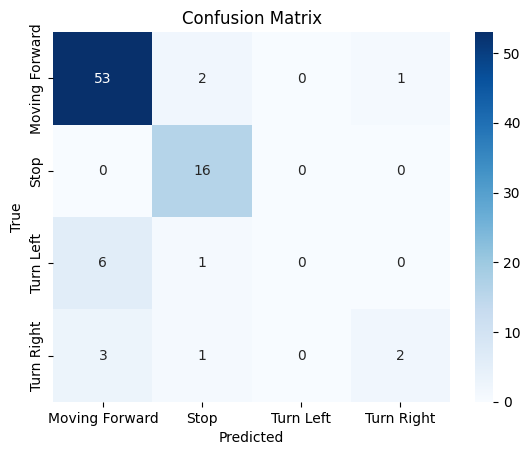

In [5]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Display classification report with zero_division handling
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Compute and display confusion matrix
labels = sorted(set(y_test))  # Ensures all true labels are included
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

# Visualize confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


                 Feature  Importance
11           Accel_Y_var    0.269800
2   Accel_Y_rolling_mean    0.106447
8              Roll_mean    0.095183
6           Accel_X_mean    0.074930
5          Pitch_var_log    0.067321
1         Gyro_magnitude    0.063699
9             Pitch_mean    0.063168
3     Gyro_X_rolling_var    0.061323
4            Yaw_var_log    0.059715
10               Yaw_var    0.055143
7            Gyro_Y_mean    0.045247
0        Accel_magnitude    0.038025


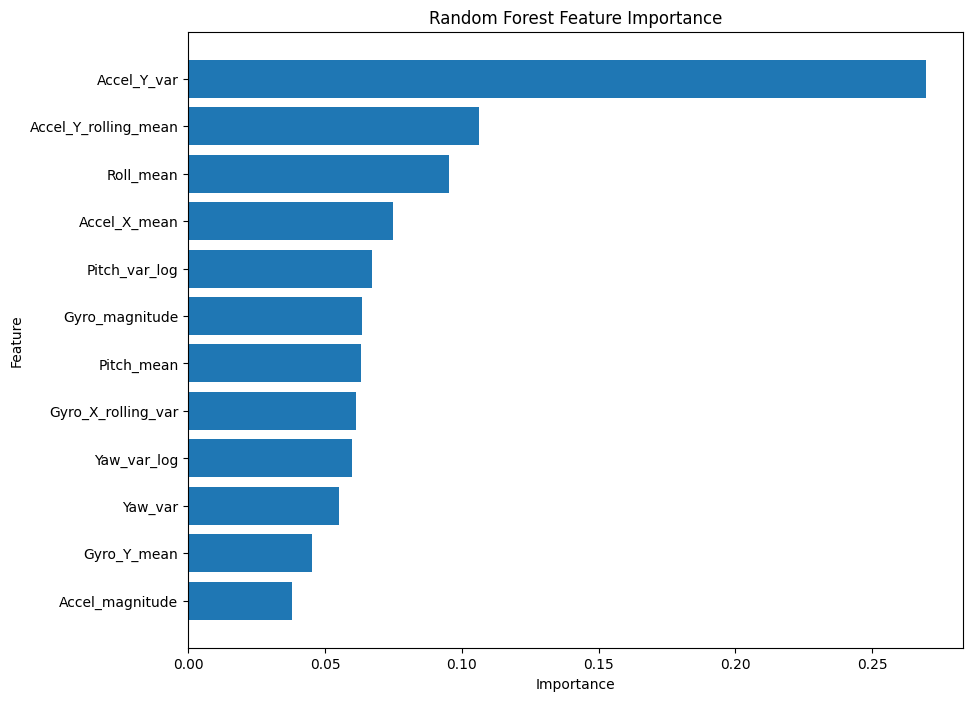

In [6]:
# Visualize feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Reverse the y-axis for better readability
plt.show()

## Model Training Results

### Confusion Matrix
The confusion matrix shows the following results:
- **Moving Forward**: Predicted correctly most of the time (53 out of 56).
- **Stop**: Predicted correctly for all samples (16 out of 16).
- **Turn Left**: Poor performance (0 samples correctly classified out of 7).
- **Turn Right**: Poor performance (2 out of 6 samples correctly classified).

### Classification Report
| Label            | Precision | Recall | F1-Score | Support |
|-------------------|-----------|--------|----------|---------|
| **Moving Forward** | 0.85      | 0.95   | 0.90     | 56      |
| **Stop**          | 0.80      | 1.00   | 0.89     | 16      |
| **Turn Left**     | 0.00      | 0.00   | 0.00     | 7       |
| **Turn Right**    | 0.67      | 0.33   | 0.44     | 6       |

- **Overall Accuracy**: 84%
- **Macro Average (F1)**: 56%
- **Weighted Average (F1)**: 79%

### Observations
1. **Imbalance Issue**:
   - The dataset is heavily imbalanced, with most samples belonging to the **Moving Forward** class, while **Turn Left** and **Turn Right** are underrepresented.
   - This imbalance likely skews the model’s predictions towards the majority classes.
2. **Poor Performance on Minority Classes**:
   - The model performs poorly on **Turn Left** and **Turn Right**, which might be due to:
     - Insufficient data for these classes.
     - Overlapping features between these labels and others.
3. **Room for Feature Improvement**:
   - Features relevant to directional motion (e.g., gyroscopic data) may need to be better engineered or emphasized to improve classification.

---

## Recommended Steps to Address Issues

### 1. Revisit Feature Engineering
- Focus on features that might distinguish **Turn Left** and **Turn Right**:
  - Gyroscopic features: `Gyro_Y_mean`, `Gyro_Z_mean`, `Yaw_mean`, etc.
  - Rolling averages or variances of yaw and pitch data.
- Create new features:
  - **Differential Features**:
    - Differences in yaw or gyro values over time to capture turning movements.
  - **Interaction Terms**:
    - Combine existing features to amplify directional patterns.
    - Example: `Gyro_Y_mean * Yaw_mean`.

### 2. Handle Class Imbalance
- Use one of the following techniques:
  - **Class Weighting**:
    - Add `class_weight='balanced'` in the `RandomForestClassifier` to give higher importance to minority classes.
  - **Oversampling**:
    - Use techniques like SMOTE to create synthetic samples for **Turn Left** and **Turn Right**.
  - **Undersampling**:
    - Reduce the number of samples for **Moving Forward** and **Stop** to balance the dataset.

### 3. Enhance Data Collection
- Collect additional samples focusing on the **Turn Left** and **Turn Right** classes under various conditions.
- Ensure the data captures the variation in turning movements (speed, angle, etc.).

### 4. Experiment with Other Models
- Try advanced models that handle class imbalance better:
  - Gradient boosting models like **XGBoost**, **CatBoost**, or **LightGBM**.
  - Support Vector Machines (SVM) with RBF kernels.

### 5. Stratified Sampling
- When splitting the dataset, use stratified sampling to ensure the test set maintains the class proportions:
  ```python
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
